In [202]:
import pandas as pd
import numpy as np
import warnings
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
#import psycopg2

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression

# Set random seed 
RSEED = 42
warnings.filterwarnings("ignore")

In [203]:
pip install -U airportsdata

Note: you may need to restart the kernel to use updated packages.


In [204]:
import airportsdata
# Load the airports data
airports = airportsdata.load()

# Convert the airports data into a DataFrame
airports_df = pd.DataFrame(airports)
# Transpose the DataFrame
airports_df = airports_df.transpose()
# If you want to reset the index of the transposed DataFrame
airports_df.reset_index(drop=True, inplace=True)
airports_df


,icao,iata,name,city,subd,country,elevation,lat,lon,tz,lid
0,00AA,,Aero B Ranch Airport,Leoti,Kansas,US,3435.0,38.704022,-101.473911,America/Chicago,00AA
1,00AK,,Lowell Field,Anchor Point,Alaska,US,252.0,59.948889,-151.692222,America/Anchorage,00AK
2,00AL,,Epps Airpark,Harvest,Alabama,US,820.0,34.86481,-86.770278,America/Chicago,00AL
3,00AN,,Katmai Lodge Airport,King Salmon,Alaska,US,80.0,59.093472,-156.455833,America/Anchorage,00AN
4,00AR,,Arland Airport,Bennington,Kansas,US,1352.0,38.969651,-97.601557,America/Chicago,00AR
...,...,...,...,...,...,...,...,...,...,...,...
28171,ZYXC,XEN,Xingcheng Air Base,,Liaoning,CN,30.0,40.580299,120.697998,Asia/Shanghai,
28172,ZYYJ,YNJ,Yanji Chaoyangchuan Airport,Yanji,Jilin,CN,624.0,42.882801,129.451004,Asia/Shanghai,
28173,ZYYY,,Shenyang Dongta Airport,Shenyang,Liaoning,CN,0.0,41.784401,123.496002,Asia/Shanghai,
28174,_AYM,AYM,Yas Island Seaplane Base,Yas Island,Abu Dhabi,AE,0.0,24.467,54.6103,Asia/Dubai,


In [205]:
df_train = pd.read_csv('data/train.csv')
df_train.shape
df_features = df_train.copy()
df_features

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0
...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0


In [207]:
df = df_features.copy()

In [208]:

# Splitting FLTID into two columns: airline and numeric
df[['AIRLINE', 'FLIGHT_NUMBER']] = df['FLTID'].str.split(n=1, expand=True)

In [189]:
# Convert DATOP, STD, and STA columns to datetime
df['DATOP'] = pd.to_datetime(df['DATOP'], format='%Y-%m-%d')
df['STD'] = pd.to_datetime(df['STD'], format='%Y-%m-%d %H.%M.%S')
df['STA'] = pd.to_datetime(df['STA'], format='%Y-%m-%d %H.%M.%S')

# Calculate ETD (Expected Time of Departure) and ETA (Expected Time of Arrival)
# Assuming the target column represents the duration in minutes
df['ETD'] = df['STD'] - pd.to_timedelta(df['target'], unit='m')
df['ETA'] = df['STA'] - pd.to_timedelta(df['target'], unit='m')

# Assume the actual time is the scheduled time plus the target delay
df['ATD'] = df['STD'] + pd.to_timedelta(df['Departure_Delay_Time'], unit='m')
df['ATA'] = df['STA'] + pd.to_timedelta(df['Arrival_Delay_Time'], unit='m')


In [190]:
df

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,AIRLINE,FLIGHT_NUMBER,ETD,ETA,Dep_Time_of_Day_Encoded,Arr_Time_of_Day_Encoded,Departure_Delay_Time,Arrival_Delay_Time,ATD,ATA
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,...,TU,712.0,2016-01-03 06:10:00,2016-01-03 08:35:00,0,1,630.0,775.0,2016-01-03 21:00:00,2016-01-04 01:50:00
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,...,TU,757.0,2016-01-13 14:45:00,2016-01-13 16:35:00,1,1,905.0,1015.0,2016-01-14 06:10:00,2016-01-14 09:50:00
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,...,TU,214.0,2016-01-16 04:10:00,2016-01-16 06:45:00,2,0,250.0,405.0,2016-01-16 08:20:00,2016-01-16 13:30:00
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,...,TU,480.0,2016-01-17 14:10:00,2016-01-17 17:00:00,1,1,850.0,1020.0,2016-01-18 04:20:00,2016-01-18 10:00:00
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,...,TU,338.0,2016-01-17 14:08:00,2016-01-17 15:28:00,1,1,870.0,950.0,2016-01-18 05:00:00,2016-01-18 07:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02:00:00,SCH,TU 32AIML,0.0,...,WKL,0.0,2018-07-05 23:00:00,2018-07-06 02:00:00,3,2,1380.0,1560.0,2018-07-06 22:00:00,2018-07-07 04:00:00
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09:00:00,SCH,UG AT7AT7,0.0,...,UG,3.0,2018-01-13 08:00:00,2018-01-13 09:00:00,0,0,480.0,540.0,2018-01-13 16:00:00,2018-01-13 18:00:00
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12:50:00,SCH,TU 736IOK,0.0,...,SGT,0.0,2018-11-07 05:00:00,2018-11-07 12:50:00,2,1,300.0,770.0,2018-11-07 10:00:00,2018-11-08 01:40:00
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18:45:00,ATA,TU CR9ISA,0.0,...,UG,10.0,2018-01-23 18:00:00,2018-01-23 18:45:00,3,3,1080.0,1125.0,2018-01-24 12:00:00,2018-01-24 13:30:00


In [209]:
import pandas as pd

# Assuming df is your DataFrame

# Convert object type values in the FLIGHT_NUMBER column to integers
df['FLIGHT_NUMBER'] = pd.to_numeric(df['FLIGHT_NUMBER'], errors='coerce')

# Find rows with conversion errors
conversion_errors_mask = df['FLIGHT_NUMBER'].isna()

# Drop rows with conversion errors
df = df[~conversion_errors_mask]

# Count and print the number of conversion errors
conversion_errors = conversion_errors_mask.sum()
if conversion_errors > 0:
    print("Conversion errors occurred. Some values could not be converted to integers.")
    print("Number of conversion errors dropped:", conversion_errors)
else:
    print("All values successfully converted to integers.")



Conversion errors occurred. Some values could not be converted to integers.
Number of conversion errors dropped: 3


In [116]:
df

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,AIRLINE,FLIGHT_NUMBER
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,TU,712.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,TU,757.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,TU,214.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,TU,480.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,TU,338.0
...,...,...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0,WKL,0.0
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0,UG,3.0
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0,SGT,0.0
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0,UG,10.0


In [210]:
# Selecting required columns from airports_df1
selected_airports_df = airports_df[['elevation','lat', 'lon','iata']]

# Merge for departure airport details
df1 = df.merge(selected_airports_df.rename(columns={'lat': 'dep_lat', 'lon': 'dep_lon', 'elevation': 'dep_elvation'}),
              left_on='DEPSTN', right_on='iata', how='left')

# # # Merge for arrival airport details
df2 = df1.merge(selected_airports_df.rename(columns={'lat': 'arr_lat', 'lon': 'arr_lon', 'elevation': 'arr_elvation'}),
             left_on='ARRSTN', right_on='iata', how='left')

# # # Drop the redundant 'iata' columns
# # #df.drop(['iata_x', 'iata_y'], axis=1, inplace=True)

# # # Optionally, drop other redundant columns if necessary
# # # df.drop(['DEPSTN_x', 'ARRSTN_x', 'DEPSTN_y', 'ARRSTN_y'], axis=1, inplace=True)

# # # Display the updated DataFrame
df2.drop(['iata_x', 'iata_y'], axis=1, inplace=True)
df2

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,AIRLINE,FLIGHT_NUMBER,dep_elvation,dep_lat,dep_lon,arr_elvation,arr_lat,arr_lon
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,TU,712.0,656.0,33.3675,-7.58997,22.0,36.851002,10.2272
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,TU,757.0,768.0,45.6306,8.72811,22.0,36.851002,10.2272
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,TU,214.0,22.0,36.851002,10.2272,325.0,41.275333,28.752
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,TU,480.0,19.0,33.875,10.7755,90.0,47.153198,-1.61073
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,TU,338.0,22.0,36.851002,10.2272,82.0,36.691002,3.21541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107825,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0,WKL,0.0,22.0,36.851002,10.2272,22.0,36.851002,10.2272
107826,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0,UG,3.0,19.0,33.875,10.7755,22.0,36.851002,10.2272
107827,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0,SGT,0.0,22.0,36.851002,10.2272,22.0,36.851002,10.2272
107828,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0,UG,10.0,22.0,36.851002,10.2272,19.0,33.875,10.7755


In [211]:
df = df2.copy()
# Convert DATOP column to datetime format
df['DATOP'] = pd.to_datetime(df['DATOP'])

# Extract year, month, day, and week
df['Year'] = df['DATOP'].dt.year
df['Month'] = df['DATOP'].dt.month
df['Day'] = df['DATOP'].dt.day
df['Weekday'] = df['DATOP'].dt.dayofweek  # Monday=0, Sunday=6

# Create a binary feature indicating weekday (1) or weekend (0)
df['Weekend'] = df['Weekday'].apply(lambda x: 1 if x < 5 else 0)

# Reorder columns if needed
# df = df[['FLTID','DATOP', 'Year', 'Month', 'Day', 'Weekday', 'Weekend', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS', 'AC', 'target']]

df


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,dep_lat,dep_lon,arr_elvation,arr_lat,arr_lon,Year,Month,Day,Weekday,Weekend
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,...,33.3675,-7.58997,22.0,36.851002,10.2272,2016,1,3,6,0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,...,45.6306,8.72811,22.0,36.851002,10.2272,2016,1,13,2,1
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,...,36.851002,10.2272,325.0,41.275333,28.752,2016,1,16,5,0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,...,33.875,10.7755,90.0,47.153198,-1.61073,2016,1,17,6,0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,...,36.851002,10.2272,82.0,36.691002,3.21541,2016,1,17,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107825,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0,...,36.851002,10.2272,22.0,36.851002,10.2272,2018,7,5,3,1
107826,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0,...,33.875,10.7755,22.0,36.851002,10.2272,2018,1,13,5,0
107827,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0,...,36.851002,10.2272,22.0,36.851002,10.2272,2018,11,7,2,1
107828,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0,...,36.851002,10.2272,19.0,33.875,10.7755,2018,1,23,1,1


In [212]:
# Define a dictionary mapping weekday numbers to their string representations
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Map weekday numbers to their string representations
df['DAY_OF_WEEK'] = df['Weekday'].map(weekday_map)

# Drop the original 'Weekday' column if not needed anymore
df.drop(columns=['Weekday'], inplace=True)

# Reorder columns if needed
# df = df[['FLTID','DATOP', 'Year', 'Month', 'Day', 'DAY_OF_WEEK', 'Weekend', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS', 'AC', 'target']]

# Display the updated DataFrame
#df


In [213]:
# Convert STD and STA columns to datetime objects with correct format
df['STD'] = pd.to_datetime(df['STD'], format='%Y-%m-%d %H:%M:%S')
df['STA'] = pd.to_datetime(df['STA'], format='%Y-%m-%d %H.%M.%S')

# Calculate flight duration in minutes
df['Flight_Duration'] = (df['STA'] - df['STD']).dt.total_seconds() / 60

df.head()

# Convert STD column to datetime objects with correct format
#df['STD'] = pd.to_datetime(df['STD'], format='%Y-%m-%d %H:%M:%S')

# Define function to categorize time of day
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Extract hour from STD column
df['Departure_Hour'] = df['STD'].dt.hour
# Extract hour from STA column
df['Arrival_Hour'] = df['STA'].dt.hour

# Apply categorization function to create Time of Day feature
df['Dep_Time_of_Day'] = df['Departure_Hour'].apply(categorize_time_of_day)
# Apply categorization function to create Time of Day feature
df['Arr_Time_of_Day'] = df['Arrival_Hour'].apply(categorize_time_of_day)


# Drop intermediate columns if needed
# df.drop(['Departure_Hour'], axis=1, inplace=True)

df.head()


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,Year,Month,Day,Weekend,DAY_OF_WEEK,Flight_Duration,Departure_Hour,Arrival_Hour,Dep_Time_of_Day,Arr_Time_of_Day
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,...,2016,1,3,0,Sunday,145.0,10,12,Morning,Afternoon
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,...,2016,1,13,1,Wednesday,110.0,15,16,Afternoon,Afternoon
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,...,2016,1,16,0,Saturday,155.0,4,6,Night,Morning
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,...,2016,1,17,0,Sunday,170.0,14,17,Afternoon,Afternoon
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,...,2016,1,17,0,Sunday,80.0,14,15,Afternoon,Afternoon


In [214]:
df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'AIRLINE', 'FLIGHT_NUMBER', 'dep_elvation', 'dep_lat',
       'dep_lon', 'arr_elvation', 'arr_lat', 'arr_lon', 'Year', 'Month', 'Day',
       'Weekend', 'DAY_OF_WEEK', 'Flight_Duration', 'Departure_Hour',
       'Arrival_Hour', 'Dep_Time_of_Day', 'Arr_Time_of_Day'],
      dtype='object')

In [216]:
df.AC.nunique()
df.AIRLINE.nunique()

19

In [101]:
# # Define mapping dictionary
# status_mapping = {'ATA': 0, 'DEP': 1, 'RTR': 2, 'SCH': 3, 'DEL': 4}

# # Map the values in the 'STATUS' column using the mapping dictionary
# df['STATUS'] = df['STATUS'].map(status_mapping)

# # Print the unique values in the 'STATUS' column
# print(df['STATUS'].unique()) 

[0 1 2 3 4]


In [20]:
df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'AIRLINE', 'FLIGHT_NUMBER', 'dep_elvation', 'dep_lat',
       'dep_lon', 'arr_elvation', 'arr_lat', 'arr_lon', 'Year', 'Month', 'Day',
       'Weekend', 'DAY_OF_WEEK', 'Flight_Duration', 'Departure_Hour',
       'Arrival_Hour', 'Dep_Time_of_Day', 'Arr_Time_of_Day'],
      dtype='object')

In [217]:
# Define mapping dictionary for Dep_Time_of_Day
time_of_day_mapping = {'Morning': 0, 'Afternoon': 1, 'Night': 2, 'Evening': 3}

# Map the values in the 'Dep_Time_of_Day' column using the mapping dictionary
df['Dep_Time_of_Day_Encoded'] = df['Dep_Time_of_Day'].map(time_of_day_mapping)
df['Arr_Time_of_Day_Encoded'] = df['Arr_Time_of_Day'].map(time_of_day_mapping)

# Print the unique values in the 'Dep_Time_of_Day_Encoded' column
print(df['Dep_Time_of_Day_Encoded'].unique())
print(df['Arr_Time_of_Day_Encoded'].unique())


[0 1 2 3]
[1 0 3 2]


In [218]:
df.isnull().sum()

ID                           0
DATOP                        0
FLTID                        0
DEPSTN                       0
ARRSTN                       0
STD                          0
STA                          0
STATUS                       0
AC                           0
target                       0
AIRLINE                      0
FLIGHT_NUMBER                0
dep_elvation               332
dep_lat                    332
dep_lon                    332
arr_elvation               332
arr_lat                    332
arr_lon                    332
Year                         0
Month                        0
Day                          0
Weekend                      0
DAY_OF_WEEK                  0
Flight_Duration              0
Departure_Hour               0
Arrival_Hour                 0
Dep_Time_of_Day              0
Arr_Time_of_Day              0
Dep_Time_of_Day_Encoded      0
Arr_Time_of_Day_Encoded      0
dtype: int64

In [219]:
# Drop rows with null values
df.dropna(inplace=True)

# Check for null values after dropping
print(df.isnull().sum())

ID                         0
DATOP                      0
FLTID                      0
DEPSTN                     0
ARRSTN                     0
STD                        0
STA                        0
STATUS                     0
AC                         0
target                     0
AIRLINE                    0
FLIGHT_NUMBER              0
dep_elvation               0
dep_lat                    0
dep_lon                    0
arr_elvation               0
arr_lat                    0
arr_lon                    0
Year                       0
Month                      0
Day                        0
Weekend                    0
DAY_OF_WEEK                0
Flight_Duration            0
Departure_Hour             0
Arrival_Hour               0
Dep_Time_of_Day            0
Arr_Time_of_Day            0
Dep_Time_of_Day_Encoded    0
Arr_Time_of_Day_Encoded    0
dtype: int64


In [220]:
# Convert STD and STA columns to datetime format
df['STD'] = pd.to_datetime(df['STD'])
df['STA'] = pd.to_datetime(df['STA'])

# Calculate departure delay time (in minutes)
df['Departure_Delay_Time'] = (df['STD'] - df['DATOP']).dt.total_seconds() / 60
df.loc[df['Departure_Delay_Time'] < 0, 'Departure_Delay_Time'] = 0  # Replace negative values with zero

# Calculate arrival delay time (in minutes)
df['Arrival_Delay_Time'] = (df['STA'] - df['DATOP']).dt.total_seconds() / 60
df.loc[df['Arrival_Delay_Time'] < 0, 'Arrival_Delay_Time'] = 0  # Replace negative values with zero

# Display the DataFrame with new columns
df[['STD', 'STA', 'DATOP', 'Departure_Delay_Time', 'Arrival_Delay_Time']]


,STD,STA,DATOP,Departure_Delay_Time,Arrival_Delay_Time
0,2016-01-03 10:30:00,2016-01-03 12:55:00,2016-01-03,630.0,775.0
1,2016-01-13 15:05:00,2016-01-13 16:55:00,2016-01-13,905.0,1015.0
2,2016-01-16 04:10:00,2016-01-16 06:45:00,2016-01-16,250.0,405.0
3,2016-01-17 14:10:00,2016-01-17 17:00:00,2016-01-17,850.0,1020.0
4,2016-01-17 14:30:00,2016-01-17 15:50:00,2016-01-17,870.0,950.0
...,...,...,...,...,...
107825,2018-07-05 23:00:00,2018-07-06 02:00:00,2018-07-05,1380.0,1560.0
107826,2018-01-13 08:00:00,2018-01-13 09:00:00,2018-01-13,480.0,540.0
107827,2018-11-07 05:00:00,2018-11-07 12:50:00,2018-11-07,300.0,770.0
107828,2018-01-23 18:00:00,2018-01-23 18:45:00,2018-01-23,1080.0,1125.0


In [221]:
df

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,DAY_OF_WEEK,Flight_Duration,Departure_Hour,Arrival_Hour,Dep_Time_of_Day,Arr_Time_of_Day,Dep_Time_of_Day_Encoded,Arr_Time_of_Day_Encoded,Departure_Delay_Time,Arrival_Delay_Time
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,...,Sunday,145.0,10,12,Morning,Afternoon,0,1,630.0,775.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,...,Wednesday,110.0,15,16,Afternoon,Afternoon,1,1,905.0,1015.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,...,Saturday,155.0,4,6,Night,Morning,2,0,250.0,405.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,...,Sunday,170.0,14,17,Afternoon,Afternoon,1,1,850.0,1020.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,...,Sunday,80.0,14,15,Afternoon,Afternoon,1,1,870.0,950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107825,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02:00:00,SCH,TU 32AIML,0.0,...,Thursday,180.0,23,2,Evening,Night,3,2,1380.0,1560.0
107826,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09:00:00,SCH,UG AT7AT7,0.0,...,Saturday,60.0,8,9,Morning,Morning,0,0,480.0,540.0
107827,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12:50:00,SCH,TU 736IOK,0.0,...,Wednesday,470.0,5,12,Night,Afternoon,2,1,300.0,770.0
107828,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18:45:00,ATA,TU CR9ISA,0.0,...,Tuesday,45.0,18,18,Evening,Evening,3,3,1080.0,1125.0


In [222]:
pip install geopy


Note: you may need to restart the kernel to use updated packages.


In [223]:
from geopy.distance import geodesic

# Calculate geographical distance between two points
def calculate_distance(row):
    dep_coords = (row['dep_lat'], row['dep_lon'])
    arr_coords = (row['arr_lat'], row['arr_lon'])
    return geodesic(dep_coords, arr_coords).kilometers

# Apply the function to the DataFrame
df['Distance'] = df.apply(calculate_distance, axis=1)


In [224]:
from geopy.distance import geodesic
import numpy as np

# Define a function to calculate the bearing angle between two coordinates
def calculate_bearing(dep_coords, arr_coords):
    # Calculate the geographical distance between two points
    distance = geodesic(dep_coords, arr_coords).miles
    
    # Calculate the bearing angle
    bearing = np.arctan2(arr_coords[1] - dep_coords[1], arr_coords[0] - dep_coords[0])
    bearing = np.degrees(bearing)
    bearing = (bearing + 360) % 360  # Convert bearing to range [0, 360)
    
    return bearing

# Apply the function to each row of the dataset
bearing_values = []
for index, row in df.iterrows():
    dep_coords = (row['dep_lat'], row['dep_lon'])  # Replace 'dep_lat' and 'dep_lon' with actual column names
    arr_coords = (row['arr_lat'], row['arr_lon'])  # Replace 'arr_lat' and 'arr_lon' with actual column names
    bearing = calculate_bearing(dep_coords, arr_coords)
    bearing_values.append(bearing)

# Add the calculated bearing values as a new column in the dataset
df['bearing'] = bearing_values




In [225]:
# Define a function to categorize bearing angles into directional categories
def categorize_direction(bearing):
    if bearing >= 337.5 or bearing < 22.5:
        return 'North'
    elif 22.5 <= bearing < 67.5:
        return 'Northeast'
    elif 67.5 <= bearing < 112.5:
        return 'East'
    elif 112.5 <= bearing < 157.5:
        return 'Southeast'
    elif 157.5 <= bearing < 202.5:
        return 'South'
    elif 202.5 <= bearing < 247.5:
        return 'Southwest'
    elif 247.5 <= bearing < 292.5:
        return 'West'
    elif 292.5 <= bearing < 337.5:
        return 'Northwest'

# Apply the function to create a new feature representing the direction
df['direction'] = df['bearing'].apply(categorize_direction)


In [226]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'direction' column
df['direction_encoded'] = label_encoder.fit_transform(df['direction'])


In [227]:
df = df.drop(['direction'],axis =1)

In [228]:
df.direction_encoded.unique()

array([0, 4, 3, 7, 5, 1, 2, 6])

In [133]:
df

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,Arrival_Hour,Dep_Time_of_Day,Arr_Time_of_Day,Dep_Time_of_Day_Encoded,Arr_Time_of_Day_Encoded,Departure_Delay_Time,Arrival_Delay_Time,Distance,bearing,direction_encoded
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,...,12,Morning,Afternoon,0,1,630.0,775.0,1666.949101,78.937437,0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,...,16,Afternoon,Afternoon,1,1,905.0,1015.0,983.064595,170.310367,4
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,...,6,Night,Morning,2,0,250.0,405.0,1673.053088,76.567513,0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,...,17,Afternoon,Afternoon,1,1,850.0,1020.0,1805.107067,316.990515,3
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,...,15,Afternoon,Afternoon,1,1,870.0,950.0,626.108971,268.692812,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107825,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02:00:00,SCH,TU 32AIML,0.0,...,2,Evening,Night,3,2,1380.0,1560.0,0.000000,0.000000,1
107826,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09:00:00,SCH,UG AT7AT7,0.0,...,9,Morning,Morning,0,0,480.0,540.0,333.916459,349.560851,1
107827,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12:50:00,SCH,TU 736IOK,0.0,...,12,Night,Afternoon,2,1,300.0,770.0,0.000000,0.000000,1
107828,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18:45:00,ATA,TU CR9ISA,0.0,...,18,Evening,Evening,3,3,1080.0,1125.0,333.916459,169.560851,4


In [229]:
import pandas as pd

# Assuming df is your DataFrame with the flight data

# Calculate frequency of each flight status category
status_frequency = df['STATUS'].value_counts(normalize=True)

# Create a new column for frequency encoding
df['Status_Frequency_Encoded'] = df['STATUS'].map(status_frequency)

df[['STATUS', 'Status_Frequency_Encoded']]


,STATUS,Status_Frequency_Encoded
0,ATA,0.867956
1,ATA,0.867956
2,ATA,0.867956
3,ATA,0.867956
4,ATA,0.867956
...,...,...
107825,SCH,0.123543
107826,SCH,0.123543
107827,SCH,0.123543
107828,ATA,0.867956


In [248]:
#['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DAY_OF_WEEK']
dums = ['AIRLINE','DEPSTN','ARRSTN'] #,'STATUS','DAY_OF_WEEK']
df_cat=pd.get_dummies(df[dums],drop_first=True)
# Convert boolean values to integers (0 and 1)
df_cat = df_cat.astype(int)

# Display the resulting DataFrame with dummy variables
df_cat

,AIRLINE_20M,AIRLINE_6YE,AIRLINE_A,AIRLINE_AOG,AIRLINE_AT,AIRLINE_AUI,AIRLINE_C,AIRLINE_D4,AIRLINE_DAT,AIRLINE_GJT,...,ARRSTN_TRN,ARRSTN_TUN,ARRSTN_VCE,ARRSTN_VIE,ARRSTN_VKO,ARRSTN_VNO,ARRSTN_VOG,ARRSTN_VRN,ARRSTN_YUL,ARRSTN_ZRH
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107825,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
107826,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
107827,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
107828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'AIRLINE', 'FLIGHT_NUMBER', 'dep_elvation', 'dep_lat',
       'dep_lon', 'arr_elvation', 'arr_lat', 'arr_lon', 'Year', 'Month', 'Day',
       'Weekend', 'DAY_OF_WEEK', 'Flight_Duration', 'Departure_Hour',
       'Arrival_Hour', 'Dep_Time_of_Day', 'Arr_Time_of_Day',
       'Dep_Time_of_Day_Encoded', 'Arr_Time_of_Day_Encoded',
       'Departure_Delay_Time', 'Arrival_Delay_Time', 'Distance', 'bearing',
       'direction_encoded', 'Status_Frequency_Encoded'],
      dtype='object')

In [163]:
df.columns

Index(['target', 'FLIGHT_NUMBER', 'dep_elvation', 'dep_lat', 'dep_lon',
       'arr_elvation', 'arr_lat', 'arr_lon', 'Year', 'Month',
       ...
       'STATUS_DEL', 'STATUS_DEP', 'STATUS_RTR', 'STATUS_SCH',
       'DAY_OF_WEEK_Monday', 'DAY_OF_WEEK_Saturday', 'DAY_OF_WEEK_Sunday',
       'DAY_OF_WEEK_Thursday', 'DAY_OF_WEEK_Tuesday', 'DAY_OF_WEEK_Wednesday'],
      dtype='object', length=307)

In [249]:
df=numerical_features[['dep_elvation','dep_lat','Status_Frequency_Encoded', 'Distance','target']]
df=pd.concat([df,df_cat],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107169 entries, 0 to 107829
Columns: 279 entries, dep_elvation to ARRSTN_ZRH
dtypes: float64(5), int64(274)
memory usage: 228.9 MB


In [232]:
# Assuming df is your DataFrame containing the dataset
# Check the count of 0 and non-zero values in the target variable
target_counts = df['target'].value_counts()

# Print the counts
print("Count of 0 in the target variable:", target_counts.get(0, 0))
print("Count of non-zero values in the target variable:", target_counts.sum() - target_counts.get(0, 0))


Count of 0 in the target variable: 37965
Count of non-zero values in the target variable: 69204


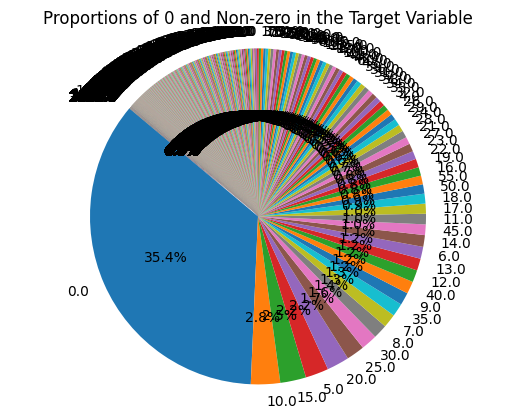

In [233]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the dataset
# Check the count of 0 and non-zero values in the target variable
target_counts = df['target'].value_counts()

# Plotting the counts on a pie chart
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportions of 0 and Non-zero in the Target Variable')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



In [234]:
df = df.drop(['DAY_OF_WEEK'], axis =1)

In [235]:
# Select columns with object data type
object_columns = df.select_dtypes(include=['object'])

# Display the selected columns
print(object_columns)


                     ID      FLTID DEPSTN ARRSTN STATUS         AC AIRLINE   
0            train_id_0   TU 0712     CMN    TUN    ATA  TU 32AIMN      TU  \
1            train_id_1   TU 0757     MXP    TUN    ATA  TU 31BIMO      TU   
2            train_id_2   TU 0214     TUN    IST    ATA  TU 32AIMN      TU   
3            train_id_3   TU 0480     DJE    NTE    ATA  TU 736IOK      TU   
4            train_id_4   TU 0338     TUN    ALG    ATA  TU 320IMU      TU   
...                 ...        ...    ...    ...    ...        ...     ...   
107825  train_id_107828  WKL 0000     TUN    TUN    SCH  TU 32AIML     WKL   
107826  train_id_107829   UG 0003     DJE    TUN    SCH  UG AT7AT7      UG   
107827  train_id_107830  SGT 0000     TUN    TUN    SCH  TU 736IOK     SGT   
107828  train_id_107831   UG 0010     TUN    DJE    ATA  TU CR9ISA      UG   
107829  train_id_107832   UG 0002     TUN    DJE    SCH  TU CR9ISA      UG   

       dep_elvation    dep_lat  dep_lon arr_elvation    arr_lat

In [236]:
# Convert 'dep_lat' and 'dep_lon' to numerical values
df['dep_lat'] = pd.to_numeric(df['dep_lat'])
df['dep_lon'] = pd.to_numeric(df['dep_lon'])
df['dep_elvation'] = pd.to_numeric(df['dep_elvation'])


# Convert 'arr_lat' and 'arr_lon' to numerical values
df['arr_lat'] = pd.to_numeric(df['arr_lat'])
df['arr_lon'] = pd.to_numeric(df['arr_lon'])
df['arr_elvation'] = pd.to_numeric(df['arr_elvation'])

In [52]:
df.columns

Index(['AC', 'target', 'FLIGHT_NUMBER', 'dep_elvation', 'dep_lat', 'dep_lon',
       'arr_elvation', 'arr_lat', 'arr_lon', 'Year', 'Month', 'Day', 'Weekend',
       'DAY_OF_WEEK', 'Flight_Duration', 'Departure_Hour', 'Arrival_Hour',
       'Dep_Time_of_Day', 'Arr_Time_of_Day', 'Dep_Time_of_Day_Encoded',
       'Arr_Time_of_Day_Encoded', 'Departure_Delay_Time', 'Arrival_Delay_Time',
       'Distance', 'bearing', 'direction_encoded', 'Status_Frequency_Encoded'],
      dtype='object')

In [237]:
# Filter numerical features
numerical_features = df.select_dtypes(include=['number'])

# Display the numerical features
print(numerical_features.columns)


Index(['target', 'FLIGHT_NUMBER', 'dep_elvation', 'dep_lat', 'dep_lon',
       'arr_elvation', 'arr_lat', 'arr_lon', 'Year', 'Month', 'Day', 'Weekend',
       'Flight_Duration', 'Departure_Hour', 'Arrival_Hour',
       'Dep_Time_of_Day_Encoded', 'Arr_Time_of_Day_Encoded',
       'Departure_Delay_Time', 'Arrival_Delay_Time', 'Distance', 'bearing',
       'direction_encoded', 'Status_Frequency_Encoded'],
      dtype='object')


In [238]:
corr = numerical_features.corr()
corr.head(307)

,target,FLIGHT_NUMBER,dep_elvation,dep_lat,dep_lon,arr_elvation,arr_lat,arr_lon,Year,Month,...,Departure_Hour,Arrival_Hour,Dep_Time_of_Day_Encoded,Arr_Time_of_Day_Encoded,Departure_Delay_Time,Arrival_Delay_Time,Distance,bearing,direction_encoded,Status_Frequency_Encoded
target,1.000000,-0.000492,0.042452,-0.005857,-0.010816,0.017578,-0.024439,0.005770,0.088329,0.020760,...,0.060462,0.092637,0.057983,0.099507,0.064059,-0.002476,0.103162,0.001948,0.050358,0.151841
FLIGHT_NUMBER,-0.000492,1.000000,0.049022,-0.005726,0.130477,0.050421,-0.007557,0.131875,0.058670,0.007767,...,-0.055085,-0.034198,0.110329,0.029036,-0.053205,-0.014411,0.010403,0.024404,-0.005713,0.180970
dep_elvation,0.042452,0.049022,1.000000,0.127529,-0.011258,-0.185434,-0.171761,0.040478,0.021430,0.000720,...,0.000363,0.079405,0.004590,0.146520,0.003014,-0.006247,0.130301,-0.153017,0.110311,0.135150
dep_lat,-0.005857,-0.005726,0.127529,1.000000,-0.068357,-0.166521,0.063685,0.131533,-0.018102,0.027915,...,0.036630,0.248998,-0.307299,0.007194,0.036522,-0.003033,-0.108255,-0.088787,0.352353,0.108619
dep_lon,-0.010816,0.130477,-0.011258,-0.068357,1.000000,0.037761,0.136259,0.046426,0.006124,-0.037262,...,-0.141946,-0.049488,-0.003616,-0.083273,-0.140757,-0.005342,-0.067488,0.339780,0.176228,-0.069367
arr_elvation,0.017578,0.050421,-0.185434,-0.166521,0.037761,1.000000,0.127714,-0.011262,0.022059,0.001506,...,-0.034898,-0.015370,0.005827,-0.096278,-0.038570,-0.008925,0.131192,0.117497,-0.060667,0.135623
arr_lat,-0.024439,-0.007557,-0.171761,0.063685,0.136259,0.127714,1.000000,-0.068573,-0.018471,0.028036,...,-0.306100,-0.175411,-0.281469,-0.392289,-0.307616,-0.023784,-0.103980,0.327309,-0.338241,0.108289
arr_lon,0.005770,0.131875,0.040478,0.131533,0.046426,-0.011262,-0.068573,1.000000,0.006171,-0.037104,...,0.047078,-0.008771,0.095796,0.052279,0.048741,0.005010,-0.069708,-0.389985,-0.251677,-0.069693
Year,0.088329,0.058670,0.021430,-0.018102,0.006124,0.022059,-0.018471,0.006171,1.000000,-0.056274,...,0.002369,0.011262,0.014999,0.018912,0.002297,0.004045,0.040485,-0.010320,-0.000268,0.035160
Month,0.020760,0.007767,0.000720,0.027915,-0.037262,0.001506,0.028036,-0.037104,-0.056274,1.000000,...,0.003357,0.004754,-0.012846,0.001788,0.003266,-0.000223,0.005017,-0.004612,-0.001521,0.028655


In [240]:

# Calculate correlations
correlation_matrix = numerical_features.corr().abs()

# Get the upper triangle of the correlation matrix (excluding diagonal)
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find pairs of features with correlation greater than 0.5
high_correlation_pairs = [(i, j) for i in range(len(upper_triangle.columns))
                          for j in range(i+1, len(upper_triangle.columns))
                          if upper_triangle.iloc[i, j] > 0.5]

# Find features with correlation greater than 0.1 with the target
correlation_with_target = correlation_matrix['target'].abs()
selected_features_with_target = correlation_with_target[correlation_with_target > 0.1].index.tolist()

# Print pairs of highly correlated features
print("Pairs of highly correlated features (correlation > 0.5):")
for pair in high_correlation_pairs:
    print(f"{df.columns[pair[0]]} - {df.columns[pair[1]]}")

# Print features with correlation greater than 0.1 with the target
print("\nFeatures with correlation greater than 0.1 with the target:")
print(selected_features_with_target)


Pairs of highly correlated features (correlation > 0.5):
dep_elvation - Year
dep_lat - dep_lon
dep_lat - arr_elvation
dep_lat - arr_lat
dep_lat - arr_lon
dep_lon - arr_lat
dep_lon - arr_lon
arr_elvation - arr_lat
arr_elvation - arr_lon
arr_lat - arr_lon

Features with correlation greater than 0.1 with the target:
['target', 'Distance', 'Status_Frequency_Encoded']


In [243]:
import pandas as pd

# Assuming df is your DataFrame containing the dataset

# Select features and target variable
features =numerical_features.drop(columns=['target'])  # Drop the target variable from features
target = numerical_features['target']

# Calculate correlations
correlation_matrix = numerical_features.corr()
correlation_with_target = correlation_matrix['target'].abs().sort_values(ascending=False)

# Print correlation with target variable
print("Correlation with target variable:\n", correlation_with_target)

# Select features with correlation above a certain threshold (e.g., 0.1)
threshold = 0.1
selected_features = correlation_with_target[correlation_with_target > threshold].index.tolist()

# Print selected features
print("\nSelected features with correlation above threshold:", selected_features)


Correlation with target variable:
 target                      1.000000
Status_Frequency_Encoded    0.151841
Distance                    0.103162
Arr_Time_of_Day_Encoded     0.099507
Arrival_Hour                0.092637
Year                        0.088329
Departure_Delay_Time        0.064059
Departure_Hour              0.060462
Dep_Time_of_Day_Encoded     0.057983
direction_encoded           0.050358
dep_elvation                0.042452
Weekend                     0.036949
arr_lat                     0.024439
Month                       0.020760
arr_elvation                0.017578
dep_lon                     0.010816
Flight_Duration             0.006368
dep_lat                     0.005857
arr_lon                     0.005770
Day                         0.005126
Arrival_Delay_Time          0.002476
bearing                     0.001948
FLIGHT_NUMBER               0.000492
Name: target, dtype: float64

Selected features with correlation above threshold: ['target', 'Status_Frequency_Enc

In [246]:
df_corr = pd.DataFrame(corr)

# Filter features that have correlation > 0.1 with the target
high_corr_features = df_corr[df_corr['target'].abs() > 0.1]

# Remove features that have correlation > 0.5 with other features
independent_features = high_corr_features.loc[:, (high_corr_features.abs() < 0.5).all()]

# Print the independent features
print("Independent features:")
print(independent_features.columns.tolist())

Independent features:
['FLIGHT_NUMBER', 'dep_elvation', 'dep_lat', 'dep_lon', 'arr_elvation', 'arr_lat', 'arr_lon', 'Year', 'Month', 'Day', 'Weekend', 'Flight_Duration', 'Departure_Hour', 'Arrival_Hour', 'Dep_Time_of_Day_Encoded', 'Arr_Time_of_Day_Encoded', 'Departure_Delay_Time', 'Arrival_Delay_Time', 'bearing', 'direction_encoded']


In [ ]:
'FLIGHT_NUMBER', 'dep_elvation', 'dep_lat', 'dep_lon', 'arr_elvation', 'arr_lat', 'arr_lon', 'Year', 'Month', 'Day', 'Weekday', 'Weekend', 'Flight_Duration', 'Departure_Hour', 'Arrival_Hour', 'Dep_Time_of_Day_Encoded', 'Arr_Time_of_Day_Encoded', 'bearing', 'direction_encoded'

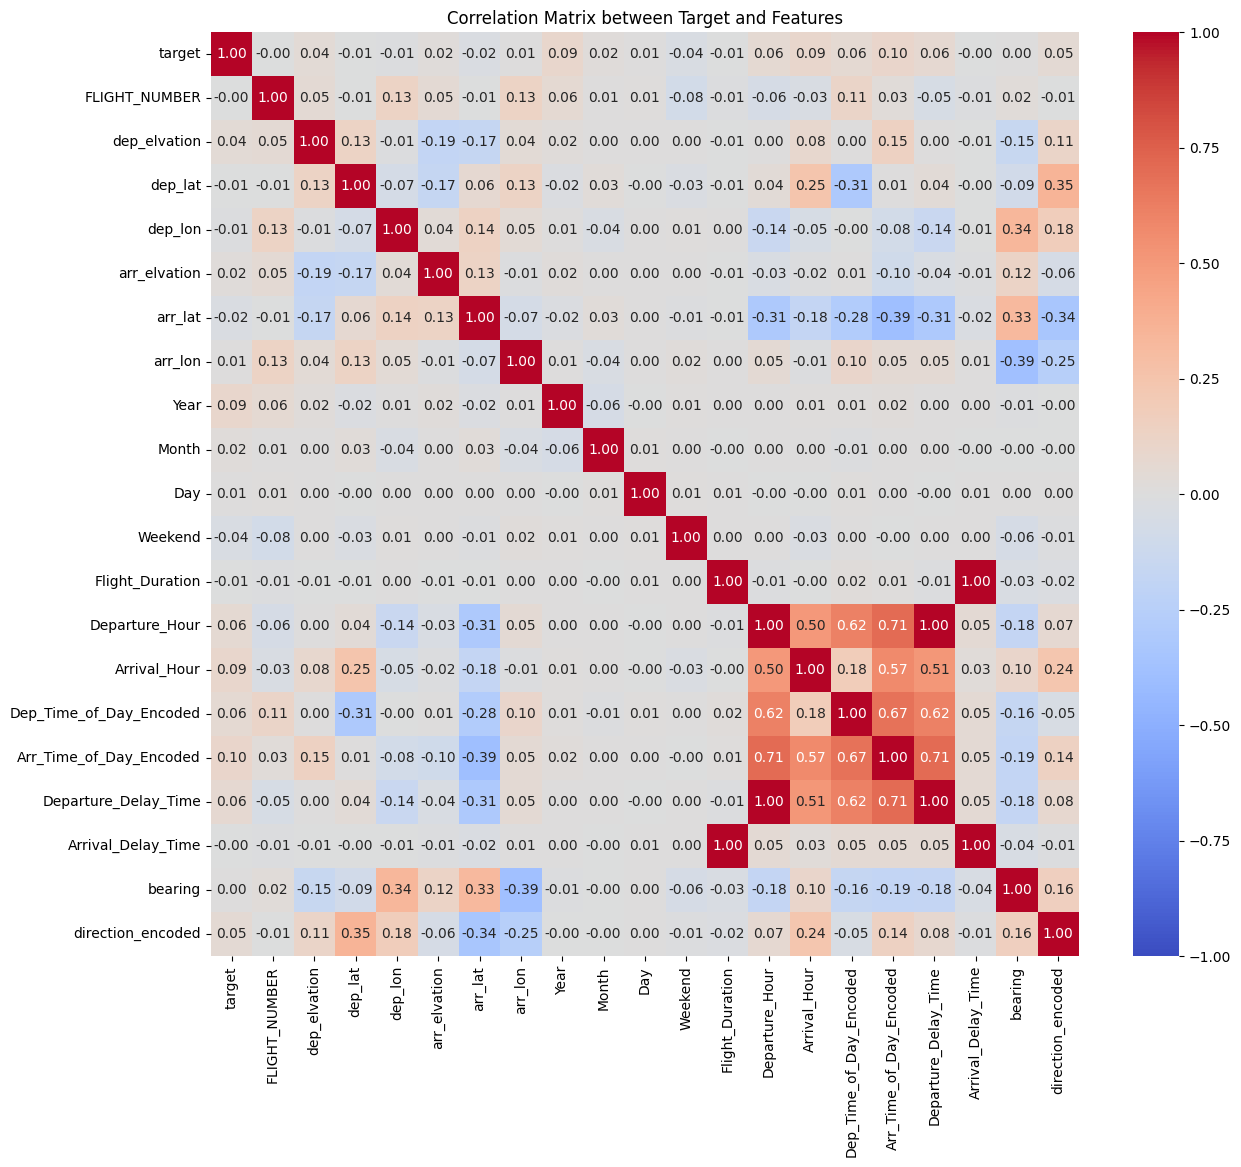

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and target is your target variable

# Specify the features

features = ['target','FLIGHT_NUMBER', 'dep_elvation', 'dep_lat', 'dep_lon', 'arr_elvation', 'arr_lat', 'arr_lon', 'Year', 'Month', 'Day', 'Weekend', 'Flight_Duration', 'Departure_Hour', 'Arrival_Hour', 'Dep_Time_of_Day_Encoded', 'Arr_Time_of_Day_Encoded', 'Departure_Delay_Time', 'Arrival_Delay_Time', 'bearing', 'direction_encoded']

df_new = df[features].copy()
# Compute the correlation matrix
corr_matrix = df[features].corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin = -1, vmax =1,fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix between Target and Features')
plt.show()


In [92]:
df_new

,dep_elvation,Year,Departure_Hour,Arrival_Hour,Dep_Time_of_Day_Encoded,Arr_Time_of_Day_Encoded,Departure_Delay_Time,Distance,direction_encoded,Status_Frequency_Encoded,...,STATUS_DEL,STATUS_DEP,STATUS_RTR,STATUS_SCH,DAY_OF_WEEK_Monday,DAY_OF_WEEK_Saturday,DAY_OF_WEEK_Sunday,DAY_OF_WEEK_Thursday,DAY_OF_WEEK_Tuesday,DAY_OF_WEEK_Wednesday
0,656.0,2016,10,12,0.0,1,630.0,1666.949101,0,0.867956,...,0,0,0,0,0,0,1,0,0,0
1,768.0,2016,15,16,1.0,1,905.0,983.064595,4,0.867956,...,0,0,0,0,0,0,0,0,0,1
2,22.0,2016,4,6,2.0,0,250.0,1673.053088,0,0.867956,...,0,0,0,0,0,1,0,0,0,0
3,19.0,2016,14,17,1.0,1,850.0,1805.107067,3,0.867956,...,0,0,0,0,0,0,1,0,0,0
4,22.0,2016,14,15,1.0,1,870.0,626.108971,7,0.867956,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107825,22.0,2018,23,2,2.5,2,1380.0,0.000000,1,0.867956,...,0,0,0,1,0,0,0,1,0,0
107826,19.0,2018,8,9,0.0,0,480.0,333.916459,1,0.867956,...,0,0,0,1,0,1,0,0,0,0
107827,22.0,2018,5,12,2.0,1,300.0,0.000000,1,0.867956,...,0,0,0,1,0,0,0,0,0,1
107828,22.0,2018,18,18,2.5,3,1080.0,333.916459,4,0.867956,...,0,0,0,0,0,0,0,0,1,0


In [247]:
# Drop rows with null values
#df.dropna(inplace=True)

# Check for null values after dropping
print(df.isnull().sum())

ID                          0
DATOP                       0
FLTID                       0
DEPSTN                      0
ARRSTN                      0
STD                         0
STA                         0
STATUS                      0
AC                          0
target                      0
AIRLINE                     0
FLIGHT_NUMBER               0
dep_elvation                0
dep_lat                     0
dep_lon                     0
arr_elvation                0
arr_lat                     0
arr_lon                     0
Year                        0
Month                       0
Day                         0
Weekend                     0
Flight_Duration             0
Departure_Hour              0
Arrival_Hour                0
Dep_Time_of_Day             0
Arr_Time_of_Day             0
Dep_Time_of_Day_Encoded     0
Arr_Time_of_Day_Encoded     0
Departure_Delay_Time        0
Arrival_Delay_Time          0
Distance                    0
bearing                     0
direction_

In [70]:
df.shape

(107169, 23)

In [148]:

final_data = df.sample(n=80000)
final_data

,STATUS,target,dep_elvation,dep_lat,dep_lon,arr_elvation,arr_lat,arr_lon,Month,Day,...,ARRSTN_TRN,ARRSTN_TUN,ARRSTN_VCE,ARRSTN_VIE,ARRSTN_VKO,ARRSTN_VNO,ARRSTN_VOG,ARRSTN_VRN,ARRSTN_YUL,ARRSTN_ZRH
3953,0,25.0,22.0,36.851002,10.227200,291.0,48.725300,2.35944,7,3,...,0,0,0,0,0,0,0,0,0,0
51044,0,13.0,821.0,45.726398,5.090830,22.0,36.851002,10.22720,11,8,...,0,1,0,0,0,0,0,0,0,0
99664,0,912.0,656.0,33.367500,-7.589970,22.0,36.851002,10.22720,12,16,...,0,1,0,0,0,0,0,0,0,0
423,0,0.0,74.0,43.439272,5.221424,22.0,36.851002,10.22720,7,20,...,0,1,0,0,0,0,0,0,0,0
31146,3,0.0,22.0,36.851002,10.227200,19.0,33.875000,10.77550,11,20,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22657,0,0.0,15.0,41.804501,12.250800,22.0,36.851002,10.22720,9,29,...,0,1,0,0,0,0,0,0,0,0
71139,0,110.0,289.0,14.671111,-17.066944,1247.0,12.533500,-7.94994,3,4,...,0,0,0,0,0,0,0,0,0,0
21083,0,150.0,19.0,33.875000,10.775500,9.0,35.758099,10.75470,9,25,...,0,0,0,0,0,0,0,0,0,0
99859,0,66.0,22.0,36.851002,10.227200,291.0,48.725300,2.35944,11,9,...,0,0,0,0,0,0,0,0,0,0


In [256]:
X = numerical_features.drop(['target'],axis =1)
y = numerical_features['target']

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (85735, 22)
X_test shape: (21434, 22)
y_train shape: (85735,)
y_test shape: (21434,)


In [258]:
X_train

,FLIGHT_NUMBER,dep_elvation,dep_lat,dep_lon,arr_elvation,arr_lat,arr_lon,Year,Month,Day,...,Departure_Hour,Arrival_Hour,Dep_Time_of_Day_Encoded,Arr_Time_of_Day_Encoded,Departure_Delay_Time,Arrival_Delay_Time,Distance,bearing,direction_encoded,Status_Frequency_Encoded
61334,603.0,22.0,36.851002,10.227200,19.0,33.875000,10.775500,2017,8,15,...,12,13,1,1,730.0,785.0,333.916459,169.560851,4,0.867956
38004,282.0,22.0,36.851002,10.227200,499.0,43.629101,1.363820,2017,3,20,...,7,9,0,0,450.0,565.0,1064.304389,307.406256,3,0.867956
54480,362.0,22.0,36.851002,10.227200,123.0,44.535400,11.288700,2017,12,23,...,8,10,0,0,510.0,605.0,858.020116,7.864899,1,0.867956
68467,0.0,22.0,36.851002,10.227200,22.0,36.851002,10.227200,2017,10,29,...,20,4,3,2,1200.0,1680.0,0.000000,0.000000,1,0.123543
31286,0.0,22.0,36.851002,10.227200,22.0,36.851002,10.227200,2016,7,2,...,21,1,3,2,1260.0,1500.0,0.000000,0.000000,1,0.123543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21404,629.0,162.0,44.828300,-0.715556,22.0,36.851002,10.227200,2016,12,2,...,18,20,3,3,1105.0,1235.0,1277.089487,126.092151,5,0.867956
46189,362.0,22.0,36.851002,10.227200,123.0,44.535400,11.288700,2017,1,26,...,8,10,0,0,510.0,610.0,858.020116,7.864899,1,0.867956
42881,723.0,291.0,48.725300,2.359440,22.0,36.851002,10.227200,2017,4,22,...,17,20,1,3,1070.0,1215.0,1465.885850,146.472050,5,0.867956
43846,6498.0,19.0,33.875000,10.775500,21.0,36.075833,10.438611,2017,1,7,...,4,5,2,2,280.0,325.0,246.090591,351.297087,1,0.867956


In [259]:

from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
y_pred = reg_rf.predict(X_test)


In [252]:
reg_rf.score(X_train,y_train)


0.867097571672007

In [253]:
reg_rf.score(X_test,y_test)


0.054402924361099836

In [254]:
metrics.r2_score(y_test,y_pred)


0.054402924361099836

In [143]:

print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

MAE: 53.9132075
MSE: 16494.946010829164
RMSE: 128.432651653811


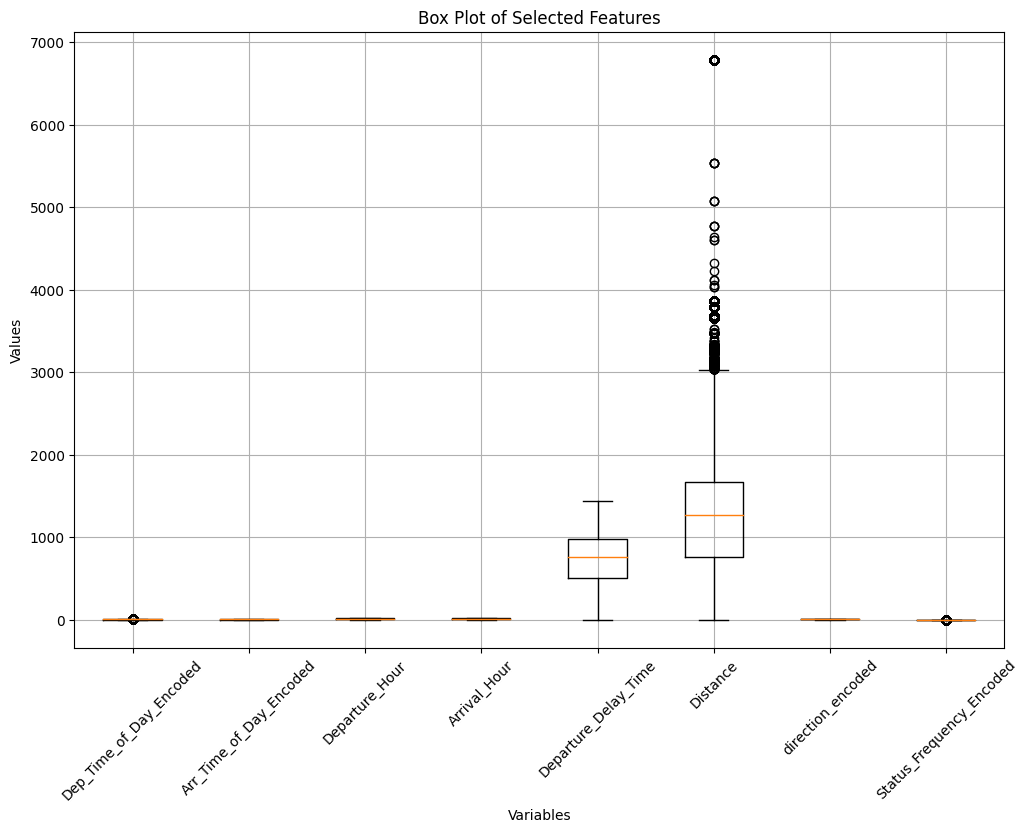

In [77]:
import matplotlib.pyplot as plt

# Define the data
data = [
    df['Dep_Time_of_Day_Encoded'], 
    df['Arr_Time_of_Day_Encoded'],  
    df['Departure_Hour'], 
    df['Arrival_Hour'], 
    df['Departure_Delay_Time'], 
    df['Distance'], 
    df['direction_encoded'], 
    df['Status_Frequency_Encoded']
]

# Define labels for the box plot
labels = [
    'Dep_Time_of_Day_Encoded', 
    'Arr_Time_of_Day_Encoded',
    'Departure_Hour', 
    'Arrival_Hour', 
    'Departure_Delay_Time', 
    'Distance', 
    'direction_encoded', 
    'Status_Frequency_Encoded'
]

# Create box plots
plt.figure(figsize=(12, 8))
plt.boxplot(data, labels=labels)
plt.title('Box Plot of Selected Features')
plt.ylabel('Values')
plt.xlabel('Variables')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [243]:
df.shape

(107833, 276)

In [239]:
df_new.columns

Index(['FLIGHT_NUMBER', 'dep_elvation', 'dep_lat', 'dep_lon', 'arr_elvation',
       'arr_lat', 'arr_lon', 'Year', 'Month', 'Day', 'Weekday', 'Weekend',
       'Flight_Duration', 'Departure_Hour', 'Arrival_Hour',
       'Dep_Time_of_Day_Encoded', 'Arr_Time_of_Day_Encoded', 'bearing',
       'direction_encoded', 'target'],
      dtype='object')

In [ ]:
'target','FLIGHT_NUMBER', 'dep_elvation', 'dep_lat', 'dep_lon', 'arr_elvation', 'arr_lat', 'arr_lon', 'Year', 'Month', 'Day', 'Weekend', 'Flight_Duration', 'Departure_Hour', 'Arrival_Hour', 'Dep_Time_of_Day_Encoded', 'Arr_Time_of_Day_Encoded', 'Departure_Delay_Time', 'Arrival_Delay_Time', 'bearing', 'direction_encoded']

In [78]:
df.Distance.skew()

1.661688148465137

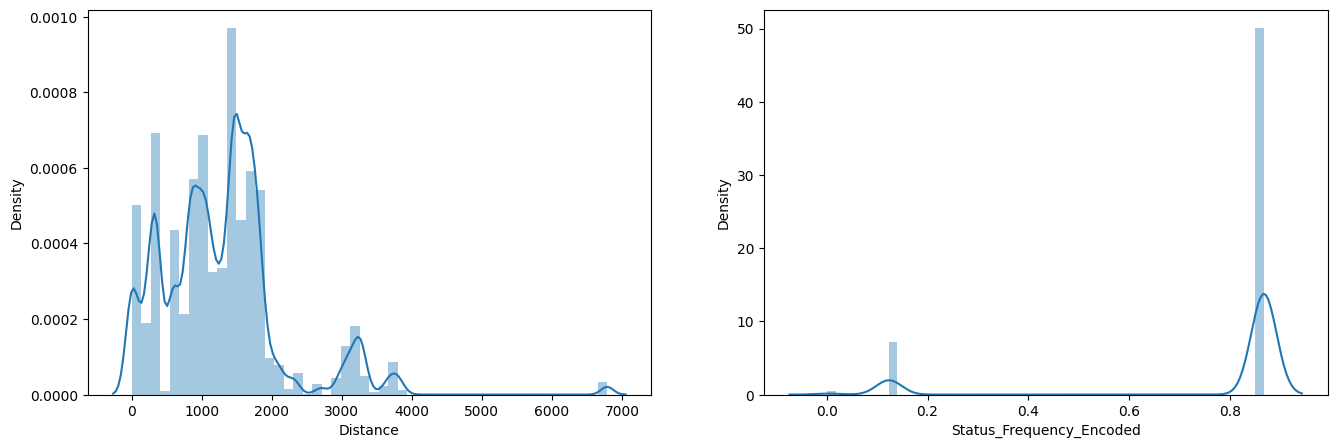

In [79]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['Distance'])

plt.subplot(1,2,2)
sns.distplot(df['Status_Frequency_Encoded'])

plt.show()

In [172]:
import pandas as pd

# Define a function to detect outliers using IQR method
def detect_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (df < lower_bound) | (df > upper_bound)
    return outliers

# Specify the columns of interest
columns_of_interest = [
    'Dep_Time_of_Day_Encoded', 
    'Arr_Time_of_Day_Encoded',
    'Departure_Hour', 
    'Arrival_Hour', 
    'Departure_Delay_Time', 
    'Distance', 
    'direction_encoded', 
    'Status_Frequency_Encoded'
]


# Extract the specified columns from the DataFrame
df_subset = df[columns_of_interest]

# Apply the function to the subset of the DataFrame
outliers = detect_outliers_iqr(df_subset)

# Count the number of outliers in each column
outliers_count = outliers.sum()

# Print the count of outliers for each column
print("Number of outliers in each column:\n", outliers_count)

# Optionally, you can sum the total number of outliers
total_outliers_count = outliers_count.sum()
print("\nTotal number of outliers:", total_outliers_count)




KeyError: "['Dep_Time_of_Day_Encoded', 'Arr_Time_of_Day_Encoded', 'Departure_Hour', 'Arrival_Hour', 'Departure_Delay_Time', 'direction_encoded'] not in index"

In [74]:
df.shape

(107169, 23)

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107169 entries, 0 to 107829
Columns: 300 entries, target to STATUS_SCH
dtypes: float64(12), int32(6), int64(282)
memory usage: 243.7 MB


In [73]:
df.isnull().sum()

STATUS                     0
target                     0
Year                       0
Month                      0
Day                        0
Weekday                    0
Weekend                    0
Flight_Duration            0
Departure_Hour             0
Arrival_Hour               0
AC_Encoded                 0
Airline_Encoded            0
FLTID_Encoded              0
Dep_Time_of_Day_Encoded    0
Arr_Time_of_Day_Encoded    0
Distance                   0
bearing                    0
direction_encoded          0
dtype: int64

In [68]:
# Drop rows with outliers
df_clean = df[~outliers.any(axis=1)]

# Print the shape of the cleaned DataFrame
print("Shape of cleaned DataFrame:", df_clean.shape)

Shape of cleaned DataFrame: (19010, 18)


In [90]:
df_clean

,STATUS,target,Year,Month,Day,Weekday,Weekend,Flight_Duration,Departure_Hour,Arrival_Hour,AC_Encoded,Airline_Encoded,FLTID_Encoded,Dep_Time_of_Day_Encoded,Arr_Time_of_Day_Encoded,Distance,bearing,direction_encoded
34272,0,59.0,2017,1,1,6,0,140.0,15,17,35,14,241,1,1,1465.885850,326.472050,3
34273,0,31.0,2017,1,8,6,0,110.0,8,9,32,14,252,0,0,1074.914869,329.941175,3
34274,0,24.0,2017,1,8,6,0,120.0,10,12,27,14,220,0,1,1165.897621,149.855801,5
34275,0,20.0,2017,1,8,6,0,75.0,15,16,34,14,278,1,1,576.912624,202.220969,4
34279,0,101.0,2017,1,8,6,0,115.0,15,17,45,14,222,1,1,1097.328070,156.312272,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70530,0,41.0,2017,7,2,6,0,80.0,13,15,44,14,140,1,1,626.108971,268.692812,7
70537,3,0.0,2017,3,25,5,0,50.0,9,10,62,14,308,0,0,292.774480,65.171393,2
70574,0,123.0,2017,7,2,6,0,145.0,14,17,48,14,240,1,1,1465.885850,146.472050,5
70664,3,0.0,2017,3,7,1,1,180.0,10,13,48,14,333,0,1,0.000000,0.000000,1


In [69]:
df_backup = df.copy()
df = df_clean.copy()

In [227]:
print(df['Dep_Time_of_Day_Encoded'].skew()) # -1.112The data is said to be left-skewed or negatively skewed
print(df['AC_Encoded'].skew())
print(df['FLTID_Encoded'].skew())

0.5879278143896298
-0.09753954904539687
1.403827522451104


In [81]:
# Calculate the quartiles
Q1 = df[[
    'Dep_Time_of_Day_Encoded', 
    'Arr_Time_of_Day_Encoded',
    'Departure_Hour', 
    'Arrival_Hour', 
    'Departure_Delay_Time', 
    'Distance', 
    'direction_encoded', 
    'Status_Frequency_Encoded'
]].quantile(0.25)
Q3 = df[[
    'Dep_Time_of_Day_Encoded', 
    'Arr_Time_of_Day_Encoded',
    'Departure_Hour', 
    'Arrival_Hour', 
    'Departure_Delay_Time', 
    'Distance', 
    'direction_encoded', 
    'Status_Frequency_Encoded'
]].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define the threshold for outliers
threshold = 1.5

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Identify outliers
outliers = ((df[[
    'Dep_Time_of_Day_Encoded', 
    'Arr_Time_of_Day_Encoded',
    'Departure_Hour', 
    'Arrival_Hour', 
    'Departure_Delay_Time', 
    'Distance', 
    'direction_encoded', 
    'Status_Frequency_Encoded'
]] < lower_bound) | (df[[
    'Dep_Time_of_Day_Encoded', 
    'Arr_Time_of_Day_Encoded',
    'Departure_Hour', 
    'Arrival_Hour', 
    'Departure_Delay_Time', 
    'Distance', 
    'direction_encoded', 
    'Status_Frequency_Encoded'
]] > upper_bound)).any(axis=1)

# Replace outliers with the upper or lower bound
df.loc[outliers, [
    'Dep_Time_of_Day_Encoded', 
    'Arr_Time_of_Day_Encoded',
    'Departure_Hour', 
    'Arrival_Hour', 
    'Departure_Delay_Time', 
    'Distance', 
    'direction_encoded', 
    'Status_Frequency_Encoded'
]] = df.loc[outliers, ['Dep_Time_of_Day_Encoded', 
    'Arr_Time_of_Day_Encoded',
    'Departure_Hour', 
    'Arrival_Hour', 
    'Departure_Delay_Time', 
    'Distance', 
    'direction_encoded', 
    'Status_Frequency_Encoded']].clip(lower=lower_bound, upper=upper_bound, axis=1)


In [290]:
df = df_clean.copy()

In [75]:
X = df.drop('target', axis = 1)
y = df['target']

In [260]:
from sklearn.feature_selection import SelectKBest, f_regression

# Define the number of features to select
k = 10  # Example: Select the top 5 features

# Initialize SelectKBest with the desired statistical test
selector = SelectKBest(score_func=f_regression, k=k)

# Fit the selector to your data and transform the features
X_new = selector.fit_transform(X, y)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_indices]

# Print the names of the selected features
print("Selected Features:", selected_features)

# ['Day', 'Weekday', 'Weekend', 'Flight_Duration', 'Departure_Hour',
#        'Arrival_Hour', 'FLTID_Encoded', 'Dep_Time_of_Day_Encoded',
#        'Arr_Time_of_Day_Encoded', 'Distance']


Selected Features: Index(['dep_elvation', 'Year', 'Departure_Hour', 'Arrival_Hour',
       'Dep_Time_of_Day_Encoded', 'Arr_Time_of_Day_Encoded',
       'Departure_Delay_Time', 'Distance', 'direction_encoded',
       'Status_Frequency_Encoded'],
      dtype='object')


In [242]:
df

,target,FLIGHT_NUMBER,dep_elvation,dep_lat,dep_lon,arr_elvation,arr_lat,arr_lon,Year,Month,...,ARRSTN_VKO,ARRSTN_VNO,ARRSTN_VOG,ARRSTN_VRN,ARRSTN_YUL,ARRSTN_ZRH,STATUS_DEL,STATUS_DEP,STATUS_RTR,STATUS_SCH
0,260.0,712.0,656.0,33.367500,-7.58997,22.0,36.851002,10.22720,2016,1,...,0,0,0,0,0,0,0,0,0,0
1,20.0,757.0,768.0,45.630600,8.72811,22.0,36.851002,10.22720,2016,1,...,0,0,0,0,0,0,0,0,0,0
2,0.0,214.0,22.0,36.851002,10.22720,325.0,41.275333,28.75200,2016,1,...,0,0,0,0,0,0,0,0,0,0
3,0.0,480.0,19.0,33.875000,10.77550,90.0,47.153198,-1.61073,2016,1,...,0,0,0,0,0,0,0,0,0,0
4,22.0,338.0,22.0,36.851002,10.22720,82.0,36.691002,3.21541,2016,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107164,0.0,0.0,22.0,36.851002,10.22720,22.0,36.851002,10.22720,2018,7,...,0,0,0,0,0,0,0,0,0,1
107165,0.0,3.0,19.0,33.875000,10.77550,22.0,36.851002,10.22720,2018,1,...,0,0,0,0,0,0,0,0,0,1
107166,0.0,0.0,22.0,36.851002,10.22720,22.0,36.851002,10.22720,2018,11,...,0,0,0,0,0,0,0,0,0,1
107167,0.0,10.0,22.0,36.851002,10.22720,19.0,33.875000,10.77550,2018,1,...,0,0,0,0,0,0,0,0,0,0


In [261]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the features of interest
features = ['dep_elvation', 'Year', 'Departure_Hour', 'Arrival_Hour',
       'Dep_Time_of_Day_Encoded', 'Arr_Time_of_Day_Encoded',
       'Departure_Delay_Time', 'Distance', 'direction_encoded',
       'Status_Frequency_Encoded']

# Calculate the correlation matrix
correlation_matrix = df[features].corr()

# # Print the correlation matrix
# print("Correlation Matrix:")
# print(correlation_matrix)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()



KeyError: "['Year', 'Departure_Hour', 'Arrival_Hour', 'Dep_Time_of_Day_Encoded', 'Arr_Time_of_Day_Encoded', 'Departure_Delay_Time', 'direction_encoded'] not in index"

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the features of interest
features = ['STATUS', 'Year', 'Arrival_Hour', 'Arr_Time_of_Day_Encoded', 'FLTID_Encoded', 'Dep_Time_of_Day_Encoded', 'Departure_Hour', 'Arrival_Hour', 'AC_Encoded']

# Calculate the correlation matrix
correlation_matrix = df[features].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()


In [80]:
#X = df[['Dep_Time_of_Day_Encoded', 'Departure_Hour', 'Arrival_Hour', 'AC_Encoded']]
#X = df[['STATUS', 'Year', 'Arrival_Hour', 'Arr_Time_of_Day_Encoded',
#       'FLTID_Encoded','Dep_Time_of_Day_Encoded', 'Departure_Hour', 'Arrival_Hour', 'AC_Encoded']]
X= df[['Day', 'Weekday', 'Weekend', 'Flight_Duration', 'Departure_Hour',
       'Arrival_Hour', 'FLTID_Encoded', 'Dep_Time_of_Day_Encoded',
       'Arr_Time_of_Day_Encoded', 'Distance']]
y = df['target']

# AC_Encoded (0.078536)
# Arrival_Hour (0.092989)
# Departure_Hour (0.060898)
# Dep_Time_of_Day_Encoded (0.058791)
# STATUS (0.155119)
# Dep_Time_of_Day_Encoded (0.171472)


In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [263]:
X_train

,FLIGHT_NUMBER,dep_elvation,dep_lat,dep_lon,arr_elvation,arr_lat,arr_lon,Year,Month,Day,...,Departure_Hour,Arrival_Hour,Dep_Time_of_Day_Encoded,Arr_Time_of_Day_Encoded,Departure_Delay_Time,Arrival_Delay_Time,Distance,bearing,direction_encoded,Status_Frequency_Encoded
40185,362.0,22.0,36.851002,10.22720,22.0,36.851002,10.227200,2017,6,10,...,8,10,0,0,505.0,610.0,0.000000,0.000000,1,0.002734
82095,399.0,21.0,5.261390,-3.92629,732.0,13.481500,2.183610,2018,7,16,...,22,0,3,2,1360.0,1475.0,1129.691078,36.622940,2,0.867956
32888,0.0,22.0,36.851002,10.22720,22.0,36.851002,10.227200,2016,2,16,...,21,0,3,2,1260.0,1440.0,0.000000,0.000000,1,0.123543
72974,996.0,22.0,36.851002,10.22720,12.0,43.658401,7.215870,2018,2,14,...,7,9,0,0,470.0,560.0,797.970237,336.137260,3,0.867956
70980,997.0,12.0,43.658401,7.21587,22.0,36.851002,10.227200,2018,2,2,...,10,11,0,0,610.0,705.0,797.970237,156.137260,5,0.867956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21128,790.0,22.0,36.851002,10.22720,202.0,51.148102,-0.190278,2016,12,19,...,7,9,0,0,425.0,590.0,1790.807802,323.921321,3,0.867956
89139,217.0,325.0,41.275333,28.75200,22.0,36.851002,10.227200,2018,10,9,...,19,22,3,3,1175.0,1345.0,1673.053088,256.567513,7,0.867956
25124,6499.0,1487.0,48.353802,11.78610,21.0,36.075833,10.438611,2016,12,24,...,9,11,0,0,560.0,695.0,1368.281773,186.263064,4,0.867956
31894,0.0,22.0,36.851002,10.22720,22.0,36.851002,10.227200,2016,7,10,...,4,14,2,1,267.0,852.0,0.000000,0.000000,1,0.123543


In [1]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Assuming X_train and y_train are your feature and target variables for the training set

# # Random oversampling
# ros = RandomOverSampler(random_state=42)
# X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)

# # Random undersampling
# rus = RandomUnderSampler(random_state=42)
# X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)

# SMOTE-ENN (combination of SMOTE and Edited Nearest Neighbors)
smote_enn = SMOTEENN(random_state=42)
X_resampled_smoteenn, y_resampled_smoteenn = smote_enn.fit_resample(X_train, y_train)


NameError: name 'X_train' is not defined

In [264]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.model_selection import train_test_split


# Initialize the RandomForestRegressor model
# {'n_estimators': 113,
#  'min_samples_split': 5,
#  'min_samples_leaf': 10,
#  'max_features': 'auto',
#  'max_depth': 20}

# {'n_estimators': 113,
#  'min_samples_split': 5,
#  'min_samples_leaf': 10,
#  'max_features': 'auto',
#  'max_depth': 20}
model = RandomForestRegressor(n_estimators=103, max_depth=10, min_samples_split=5,max_features = 'auto', n_jobs=-1, min_samples_leaf=10,random_state=0)


# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Mean Squared Error: 11073.460002944867
# R^2 Score: 0.14274951379492062

# Mean Squared Error: 9434.912292752442
# R^2 Score: 0.16452554578936174

#dropped outliers
# Mean Squared Error: 11604.33614781667
# R^2 Score: 0.07078594902024538

Mean Squared Error: 12213.47728349325
R^2 Score: 0.09610715226923539


In [254]:
from sklearn.model_selection import RandomizedSearchCV
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]


# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Random search of parameters, using 5 fold cross validation,search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)
     

In [178]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=148; total time=   2.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=148; total time=   2.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=148; total time=   2.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=148; total time=   2.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=148; total time=   2.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=182; total time=   4.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=182; total time=   4.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=

KeyboardInterrupt: 

In [ ]:
rf_random.best_params_

In [ ]:
from sklearn import metrics
metrics.r2_score(y_test,y_pred)


In [88]:
print('r2_score:', metrics.r2_score(y_test,y_pred))
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

r2_score: 0.06558867516346145
MAE: 50.6665231973884
MSE: 11643.995427067368
RMSE: 107.90734649256912


In [89]:
pp=pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
pp

,Actual,Predicted
39633,0.0,32.154560
57885,0.0,32.382810
52915,41.0,57.451541
40741,355.0,23.161126
51538,275.0,94.773826
...,...,...
36819,20.0,43.536174
49263,20.0,68.855707
46240,42.0,55.037757
43928,43.0,62.028573


In [270]:
X_train

,STATUS,Year,Arrival_Hour,Arr_Time_of_Day_Encoded,FLTID_Encoded
94616,0,2018,11,0,196
40829,0,2017,12,1,214
131,0,2016,16,1,197
101400,0,2018,13,1,296
5246,0,2016,16,1,222
...,...,...,...,...,...
86104,0,2018,10,0,229
7557,0,2016,19,3,151
27271,0,2016,10,0,296
37067,0,2017,16,1,241


In [271]:

from sklearn.ensemble import GradientBoostingRegressor
gbr=GradientBoostingRegressor(random_state=0)
     

In [272]:
GBR=gbr.fit(X_train,y_train)
pre=GBR.predict(X_test)

In [273]:

print('MAE:', metrics.mean_absolute_error(y_test,pre))
print('MSE:', metrics.mean_squared_error(y_test,pre))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,pre)))

MAE: 54.288275236075975
MSE: 12709.590937117178
RMSE: 112.73682156738843


In [274]:
metrics.r2_score(y_test,pre)

0.04923004266743913

In [275]:
gbr.score(X_test, y_test)

0.04923004266743913

In [276]:
from sklearn.preprocessing import RobustScaler

# Assuming df contains only numerical columns

# Define the transformer to apply StandardScaler to all numeric columns
trf2 = ColumnTransformer([
    ('Robust_cols', RobustScaler(), slice(0, None))  # Apply StandardScaler to all columns (from the first to the last)
])

In [154]:
from sklearn.linear_model import LinearRegression

# Now you can create a LinearRegression model
model_LR = LinearRegression(n_jobs=-1)

In [155]:
#ceating pipe

pipe = Pipeline([
        #('trf1', trf1),
        ('trf2', trf2),
        ('model_LR', model_LR)
        ])

In [156]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('trf2',
                 ColumnTransformer(transformers=[('Robust_cols', RobustScaler(),
                                                  slice(0, None, None))])),
                ('model_LR', LinearRegression(n_jobs=-1))])

In [157]:
y_predict = pipe.predict(X_test)

In [158]:
from sklearn.metrics import mean_squared_error, r2_score
y_predict = pipe.predict(X_test)
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_predict)
print("Mean Squared Error:", mse)

# Calculate R^2 score
r2 = r2_score(y_test, y_predict)
print("R^2 Score:", r2)

Mean Squared Error: 10740.116091087151
R^2 Score: 0.048947955112127906


In [159]:
model_LR.score(X_test, y_test)

-211222.04279742474

In [342]:
y.shape

(107833,)

In [ ]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the dataset
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)



# Initialize the regression model
model = LinearRegression()

# Train the model on the resampled data
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)


In [338]:
pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 3.8 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
